<a href="https://colab.research.google.com/github/ms-shyamkumar/Exploratory-Data-Analysis/blob/main/Telecom_LTE_Data_Speed_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import subprocess
import glob

import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup

In [2]:
#Getting the CSV file download links from TRAI website using beautiful soup

url = "https://myspeed.trai.gov.in/"
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
links = soup.select('a[href^="download"]')
csv_urls = [url+link['href'] for link in links]

#Download all csv files
for csvs in csv_urls:
   subprocess.call(['wget', csvs])

In [ ]:
#Exploring the file structure of each file before aggregating
filenames = glob.glob('*.csv')

for filename in filenames:
  print(filename, pd.read_csv(filename, nrows=1).columns)

#Some of the files had headers and some don't

In [4]:
#exclude files with a different structure. May-18 is also excluded for continuity. 
exclude_files = ['march18_myspeed.csv', 'april18_publish.csv','may18_publish.csv','june18_publish.csv','july18_publish.csv','aug18_publish.csv']

columns = ['ServiceProvider', 'Technology', 'TestType', 'DataSpeed', 'RxLevel', 'LSA']
li = []
for filename in filenames:
  if filename not in exclude_files:
    tmp_df = pd.read_csv(filename,header=None, names=columns)
    monthyear = filename.replace('_publish.csv','')
    tmp_df['month'] = pd.to_datetime(monthyear[:3]+monthyear[-2:],format='%b%y')
    li.append(tmp_df)

df = pd.concat(li, axis=0, ignore_index=True)

print(df.shape)
df.head(3)

(17869204, 7)


,ServiceProvider,Technology,TestType,DataSpeed,RxLevel,LSA,month
0,JIO,4G,download,66391.0,-58,Karnataka,2018-11-01
1,JIO,4G,download,62756.0,-60,Karnataka,2018-11-01
2,JIO,4G,download,67135.0,-60,Karnataka,2018-11-01


In [5]:
#Data clean up and preprocessing
df.drop(df[(df['RxLevel']=='na')].index, inplace=True)
df.drop(df[(df['Technology']!='4G')].index, inplace=True)
df.drop(df[(df['ServiceProvider']=='na')].index, inplace=True)
df['RxLevel'] =  pd.to_numeric(df['RxLevel'])
print(df.shape)

aggr_df = df.groupby(['ServiceProvider','TestType', 'LSA', 'month']).mean().reset_index()
aggr_df.head(3)

(14915410, 7)


,ServiceProvider,TestType,LSA,month,DataSpeed,RxLevel
0,AIRTEL,download,Andhra Pradesh,2018-09-01,14896.257275,-96.520833
1,AIRTEL,download,Andhra Pradesh,2018-10-01,15000.379093,-96.106114
2,AIRTEL,download,Andhra Pradesh,2018-11-01,15548.537828,-94.048608


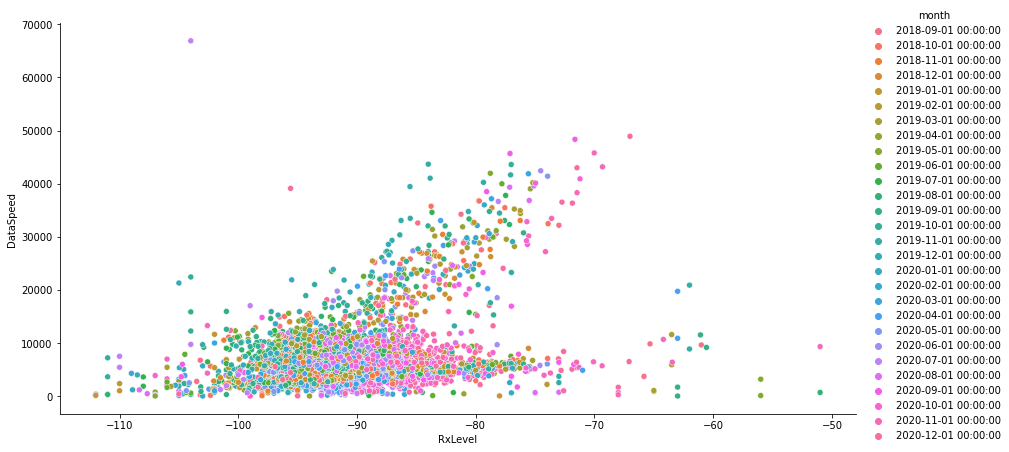

In [6]:
sns.relplot(x='RxLevel', y='DataSpeed', hue='month', data=aggr_df, aspect=2, height=6);

The scatter plot shows a divergent pattern. In general Data Speed increases with better RxLevel (Signal Strength/Coverage)
Actionable Insight:
1) Points where signal strength is poor (-100 or less) and speed is less requires coverage to be improved
2) Point where signal strength is good (-90 or better) and still speed is less means capacity has to be increased.



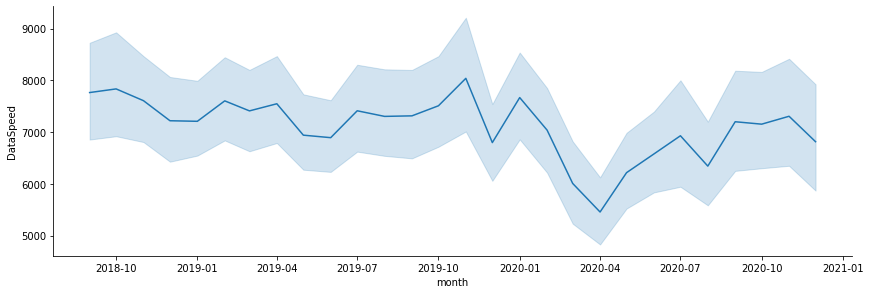

In [7]:
sns.relplot(x='month', y='DataSpeed', data=aggr_df, kind='line', aspect=3, height=4);

Data Speed has reduced since lockdown has started, probably owing to 1) Mostly Indoor usage 2) Increased traffic due to work from home.